In [3]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'

In [ ]:
# Loss function for gradcam


In [5]:
def plotGradCAM(model, scenario, image_size, images_per_class = 4, trial_seed = 1, testing=True):
    image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
    
#     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[image_size][scenario]]), 
                np.array([x[1] for x in image_sets[image_size][scenario]]), stratify= np.array([x[1] for x in image_sets[image_size][scenario]]), test_size=.2, random_state = trial_seed)

#     training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
#     training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
#     validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0)) # Sum by row
    print(validation_labels.sum(axis=0))    
    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct

    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier = model_modifier)#, clone=False)

    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    cam = gradcam(loss, gradcam_images, penultimate_layer = -4)
    cam = normalize(cam)
    print(len(cam))
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    print(cam[image_counter].shape)
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            heatmap = np.uint8(cm.jet(cam[image_counter])[..., :3] * 255)
            ax[i, j].imshow(np.squeeze(gradcam_images[image_counter], axis=2), cmap='gist_gray') #remove axes of length one from gradcam_images
            #print(heatmap.shape)
            ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing==True:
        f.savefig("../../figures/test-opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return

In [6]:
m = models.load_model('../../results/models/opt-cnn-PrPo_Im-128-px/model')

In [ ]:
?Gradcam

In [7]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       5

## Plotting the filters
The code below generates the plot of the first filter in the first convolutional layer `conv2d`.
Expand it to plot all 64 filters in a grid

In [13]:
#layer_name = 'conv2d'

layer_variables = m.get_layer('conv2d').get_weights()

weights = layer_variables[0]
biases = layer_variables[1]

w = np.array(weights)
w.shape

w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)



(64, 1, 5, 5)


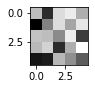

In [14]:
#the total filter in previous layers will be obtained from w.shape[1]
cols = 8
rows = 8
# rows * cols > total_filters

# current_filter = which filter's weights we want to see
current_filter = 63

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

To plot feature map activations, the `keract` library might be a good alternative: https://github.com/philipperemy/keract#display-the-activations-as-a-heatmap-overlaid-on-an-image

The example below still needs debugging but was adapted from: https://github.com/meet-minimalist/Visualize-CNN-Filters/blob/master/Visualize%20CNN%20Layer%20Outputs%20and%20Filters.ipynb

In [22]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
print(image_sets[128]['PrPo_Im'][0][0].shape)
layer_name = 'conv2d'
intermediate_layer_model = models.Model(inputs=m.input, outputs=m.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(image_sets[128]['PrPo_Im'][0][0])

print(intermediate_output.shape)

output = np.squeeze(intermediate_output)
output = np.moveaxis(output, 2, 0)

print(output.shape)

#Plot the output of the layer in depthwise manner.
 
fig = plt.figure(figsize=(40, 40))
no_filters = w[0]

cols = 8
rows = 8

for i in range(output.shape[0]):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(output[i], cmap='gray')



(128, 128)


ValueError: in user code:

    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (32, 128)


In [ ]:
#image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
plotGradCAM(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 21,  testing=True)

In [ ]:
def plotSaliency(model, scenario, image_size, images_per_class = 4, trial_seed = 1, saliency=False, testing=True):
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct
    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    

    saliency = Saliency(model, model_modifier=model_modifier)#                    clone=False)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, gradcam_images, 
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.
    saliency_map = normalize(saliency_map)
    #image_titles = class_labels
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            ax[i, j].imshow(saliency_map[image_counter], cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing == True:
        f.savefig("../../figures/test-opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return



In [ ]:
plotSaliency(m, "PrPo_Im", 128, images_per_class = 2, trial_seed = 21,  testing=True)

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Steps: 050	Losses: [[45.9476318359375]],	Regularizations: [[('TotalVariation', 79.75999450683594), ('L2Norm', 0.07771127671003342)]]
Steps: 100	Losses: [[5.315849304199219]],	Regularizations: [[('TotalVariation', 89.31621551513672), ('L2Norm', 0.07742584496736526)]]
Steps: 150	Losses: [[-36.185665130615234]],	Regularizations: [[('TotalVariation', 85.98947143554688), ('L2Norm', 0.07719002664089203)]]
Steps: 200	Losses: [[-10.488851547241211]],	Regularizations: [[('TotalVariation', 95.69629669189453), ('L2Norm', 0.07727869600057602)]]


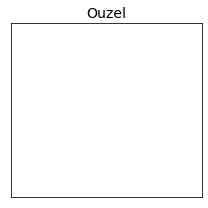

In [23]:
from tf_keras_vis.activation_maximization import ActivationMaximization

def model_modifier(m):
    """Remove softmax activation of last layer in model"""
    m.layers[-1].activation = tf.keras.activations.linear
    return m

activation_maximization = ActivationMaximization(m,
                                                 model_modifier)
                                                 
def loss(output):
    return output[:, 0]


from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()



(128, 128, 1)


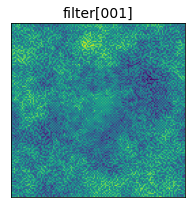

In [43]:
# Better to use activation maps for feature importance in filters
# https://github.com/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb
layer_name = 'conv2d' # The

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

activation_maximization = ActivationMaximization(m,
                                                 model_modifier,
                                                 )
filter_number = 1
def loss(output):
    return output[..., filter_number]

from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss) #,callbacks=[Print(interval=50)])
print(activation[0].shape)
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()